# Clase 6: Taller Práctico - Random Forest y Boosting

**Objetivos del Taller:**

1.  Aplicar los algoritmos de Random Forest y Gradient Boosting a un problema de clasificación.
2.  Entender cómo extraer y visualizar la importancia de las variables para interpretar los modelos.
3.  Comparar el rendimiento y las características de ambos métodos de ensamble.
4.  Experimentar con los hiperparámetros clave de cada modelo.

Utilizaremos el dataset `Heart`, que contiene datos de pacientes para predecir la presencia de enfermedades cardíacas.

In [13]:
# --- 1. Importación de Librerías --- 
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Clases de Scikit-Learn para modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix

# Librería del libro para cargar el dataset
from ISLP import load_data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y_test, models):
    cols = 2
    rows = int(np.ceil(len(models) / cols))
    
    print(f'{rows} filas, {cols} columnas')

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))  # más alto si hay más filas
    axes = np.array(axes).reshape(-1)  # aplana por si es 1D o 2D

    for i, (depth, data) in enumerate(models.items()):
        cm = confusion_matrix(y_test, data['pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Matriz de Confusión - {data['model_name']} depth: {depth}')
        axes[i].set_xlabel('Predicho')
        axes[i].set_ylabel('Verdadero')

    # Ocultar subplots sobrantes (si hay más celdas que modelos)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


## 2. Carga y Exploración de Datos

Cargaremos el dataset `Heart` desde la librería `ISLP`. Este dataset es ideal para un problema de clasificación binaria.

In [3]:
import pandas as pd

# URL canónica del dataset Heart usado en el libro ISLP
url = 'https://www.statlearning.com/s/Heart.csv'

# Usamos pandas para leer el archivo CSV directamente desde la web
heart_df = pd.read_csv(url)
# A menudo, al cargar así, se crea una columna de índice no deseada. La eliminamos.
if 'Unnamed: 0' in heart_df.columns:
    heart_df = heart_df.drop('Unnamed: 0', axis=1)

# Verificamos que los datos se hayan cargado correctamente
print('Datos cargados exitosamente desde la URL:')
display(heart_df.head())

print('\\nInformación del Dataset:')
heart_df.info()

Datos cargados exitosamente desde la URL:


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


\nInformación del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [4]:
for col_name in heart_df.select_dtypes(include=['object']).columns.tolist():
    print(f"Valores únicos en '{col_name}': {heart_df[col_name].unique()}")

Valores únicos en 'ChestPain': ['typical' 'asymptomatic' 'nonanginal' 'nontypical']
Valores únicos en 'Thal': ['fixed' 'normal' 'reversable' nan]
Valores únicos en 'AHD': ['No' 'Yes']


### 2.1. Preparación de los Datos

Para que los algoritmos de Scikit-learn funcionen correctamente, necesitamos realizar algunos pasos de preprocesamiento:

1.  **Limpieza de Nulos:** Verificar y eliminar filas con valores nulos para simplificar el análisis.
2.  **Codificación de Variables Categóricas:** Convertir columnas de texto (como `ChestPain`, `Thal`) en variables numéricas usando One-Hot Encoding.
3.  **Separación de Datos:** Dividir el dataset en un conjunto de características (`X`) y una variable objetivo (`y`).
4.  **División en Entrenamiento y Prueba:** Particionar los datos para entrenar el modelo y evaluarlo en datos no vistos.

In [5]:
# 1. Limpieza de Nulos
heart_df_clean = heart_df.dropna()

# 2. Separación de características (X) y objetivo (y)
X = heart_df_clean.drop('AHD', axis=1)
y = heart_df_clean['AHD']

#Columnas antes de one-hot
display(X.columns)
# 3. Codificación One-Hot para variables categóricas
# pd.get_dummies convierte columnas categóricas en 0s y 1s
X_encoded = pd.get_dummies(X, drop_first=True)

print('Columnas después de la codificación One-Hot:')
print(X_encoded.columns)

# 4. División en conjuntos de entrenamiento y prueba (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTamaño del set de entrenamiento: {X_train.shape[0]} muestras')
print(f'Tamaño del set de prueba: {X_test.shape[0]} muestras')

Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal'],
      dtype='object')

Columnas después de la codificación One-Hot:
Index(['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng',
       'Oldpeak', 'Slope', 'Ca', 'ChestPain_nonanginal',
       'ChestPain_nontypical', 'ChestPain_typical', 'Thal_normal',
       'Thal_reversable'],
      dtype='object')

Tamaño del set de entrenamiento: 237 muestras
Tamaño del set de prueba: 60 muestras


## 3. Random Forest

Ahora, entrenaremos nuestro primer modelo de ensamble. Un `RandomForestClassifier` es una colección de árboles de decisión entrenados en subconjuntos de datos y características, cuyas predicciones se combinan para obtener un resultado final más robusto.

In [33]:
# Instanciar el clasificador de Random Forest
# n_estimators: número de árboles en el bosque.
# random_state: para reproducibilidad de los resultados.
rf_model = RandomForestClassifier(n_estimators=100, random_state=100, oob_score=True)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el rendimiento
print("--- Evaluación de Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Error OOB (Out-of-Bag): {1 - rf_model.oob_score_:.4f}") # Error OOB
print(f"Accuracy OOB: {rf_model.oob_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

--- Evaluación de Random Forest ---
Accuracy: 0.8167
Error OOB (Out-of-Bag): 0.2025
Accuracy OOB: 0.7975

Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.88      0.84        32
         Yes       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



### 3.1. Importancia de Variables
Una de las grandes ventajas de Random Forest es que nos permite medir qué tan importante fue cada variable para la predicción. Lo visualizaremos para entender mejor qué factores influyen más en el diagnóstico.

In [34]:
# Extraer la importancia de las variables
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar con Plotly Express
fig = px.bar(
    importance_df.head(15), 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    title='Importancia de las Variables (Random Forest)',
    labels={'Feature': 'Variable', 'Importance': 'Importancia'}
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Mapeo de colores
color_map = {"Yes": "blue", "No": "red"}
ca_values = [0, 1, 2, 3]
titles = [f'Ca = {val}' for val in ca_values]
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

fig = make_subplots(rows=2, cols=2, subplot_titles=titles)

for idx, ca_val in enumerate(ca_values):
    row, col = positions[idx]
    df_plot = heart_df_clean[heart_df_clean["Ca"] == ca_val]
    show_legend = (idx == 0)
    for ahd_val in ["Yes", "No"]:
        df_class = df_plot[df_plot["AHD"] == ahd_val]
        fig.add_trace(
            go.Scatter(x=df_class["Oldpeak"], y=df_class["MaxHR"], mode="markers",
                marker=dict(color=color_map[ahd_val]), name=ahd_val, showlegend=show_legend,
            ), row=row, col=col
        )
    show_legend = False

# Set axis titles for all subplots
for r in [1, 2]:
    for c in [1, 2]:
        fig.update_xaxes(title_text="Oldpeak", row=r, col=c)
        fig.update_yaxes(title_text="MaxHR", row=r, col=c)


fig.update_layout(
    height=800,
    width=900,
    title_text="Scatter Plots by Ca Value",
    legend=dict(title="AHD")
)
fig.show()

### ❔ Preguntas para Reflexionar (Random Forest)

1.  **Experimenta con `n_estimators`**: ¿Cómo cambia el rendimiento y el error OOB si usas 10, 50, 200, o 500 árboles? ¿Hay un punto a partir del cual el rendimiento deja de mejorar significativamente?
2.  **Analiza `max_features`**: Prueba cambiar este hiperparámetro. El valor por defecto es `sqrt(p)`. ¿Qué ocurre si lo ajustas a `None` (equivalente a Bagging) o a un número muy pequeño como `2`?

## 4. Gradient Boosting

Ahora, probaremos con Gradient Boosting. A diferencia de Random Forest, este método construye los árboles de forma secuencial, donde cada nuevo árbol intenta corregir los errores de los anteriores. Es conocido por su alto rendimiento, aunque puede ser más sensible a los hiperparámetros.

In [9]:
# Instanciar el clasificador de Gradient Boosting
# n_estimators: número de árboles secuenciales.
# learning_rate: factor de contracción (shrinkage) para cada árbol.
# max_depth: profundidad máxima de cada árbol (suelen ser superficiales).
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el rendimiento
print("--- Evaluación de Gradient Boosting ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

--- Evaluación de Gradient Boosting ---
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.84      0.86        32
         Yes       0.83      0.86      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



### 4.1. Comparación de Matrices de Confusión

La precisión general es útil, pero una matriz de confusión nos da más detalles sobre el tipo de errores que comete cada modelo (Falsos Positivos vs. Falsos Negativos), lo cual es crucial en problemas médicos.

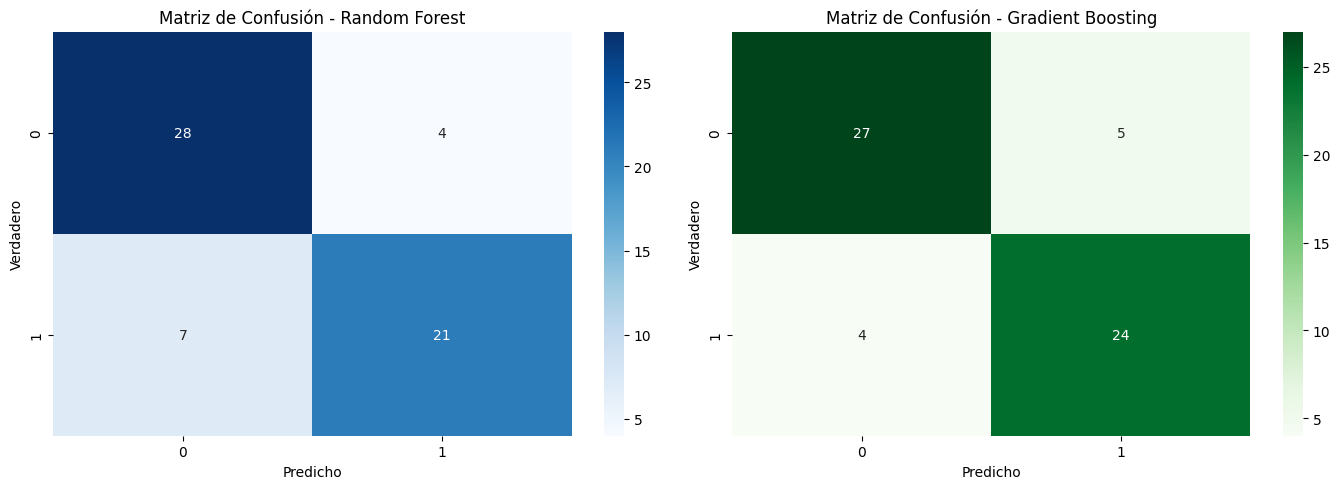

In [10]:
# Calcular matrices de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gb = confusion_matrix(y_test, y_pred_gb)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Random Forest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Verdadero')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Gradient Boosting')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Verdadero')

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import plotly.express as px
from sklearn.metrics import roc_curve, auc

# Calcular ROC y AUC para ambos modelos
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.map({"No": 0, "Yes": 1}), rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test.map({"No": 0, "Yes": 1}), gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

roc_df = pd.DataFrame({
    "FPR": list(fpr_rf) + list(fpr_gb), "TPR": list(tpr_rf) + list(tpr_gb),
    "Threshold": list(thresholds_rf) + list(thresholds_gb),
    "Model": (["Random Forest"] * len(fpr_rf)) + (["Gradient Boosting"] * len(fpr_gb))
})
fig = px.line(
    roc_df, x="FPR", y="TPR", color="Model", line_dash="Model", title="ROC Curves",
    labels={"FPR": "False Positive Rate (FPR)", "TPR": "True Positive Rate (TPR)"}, hover_data=["Threshold"]
)
fig.add_shape(
    type="line", x0=0, y0=0, x1=1, y1=1,
    line=dict(color="red", dash="dash")
)
fig.for_each_trace(
    lambda t: t.update(
        name=f"{t.name} (AUC = {roc_auc_rf:.2f})" if "Random Forest" in t.name else f"{t.name} (AUC = {roc_auc_gb:.2f})"
    )
)
fig.update_layout(
    width=800, height=500,legend=dict(
        x=0.98, y=0.02, xanchor="right", yanchor="bottom",
        bgcolor="rgba(255,255,255,0.7)", bordercolor="black", borderwidth=1)
)
fig.show()

### ❔ Preguntas para Reflexionar (Gradient Boosting)

1.  **El trade-off `learning_rate` y `n_estimators`**: Reduce el `learning_rate` a `0.01`. ¿Cómo afecta esto a la precisión? ¿Necesitas más `n_estimators` para compensar? ¿Qué pasa si aumentas el `learning_rate` a `0.5`?
2.  **Importancia de `max_depth`**: En Boosting, los árboles suelen ser superficiales. Prueba con `max_depth=1` (stumps). ¿Cómo se compara el resultado con `max_depth=3`?
3.  **Análisis de errores**: Basándote en las matrices de confusión, ¿qué modelo es mejor para minimizar los **falsos negativos** (predecir 'No' cuando en realidad es 'Sí')? ¿Por qué esto podría ser lo más importante en un contexto de diagnóstico médico?

## 5. Ejercicios Adicionales

¡Es tu turno de explorar! A continuación, se proponen 10 ejercicios para profundizar en los conceptos vistos y experimentar por tu cuenta.

1.  **Optimización de Profundidad:** Para ambos modelos (RF y GB), varía el hiperparámetro `max_depth` (ej. 2, 3, 5, 10) y analiza cómo afecta a la precisión en el conjunto de prueba. ¿Observas sobreajuste en alguno de los modelos cuando la profundidad es muy alta?

2.  **Búsqueda de Hiperparámetros con `GridSearchCV`:** Utiliza `GridSearchCV` de Scikit-learn para encontrar la combinación óptima de hiperparámetros para el `RandomForestClassifier`. Busca sobre `n_estimators`, `max_depth` y `max_features`.

3.  **Visualizar el Error OOB:** En el modelo de Random Forest, el atributo `oob_score_` se calcula sobre el ensamble final. Para visualizar la curva, entrena varios modelos con diferente `n_estimators` (de 10 a 200, por ejemplo) y grafica el error OOB (`1 - oob_score_`) en función del número de árboles.

4.  **Probar un Dataset Diferente:** Carga el dataset de cáncer de mama de Scikit-learn (`from sklearn.datasets import load_breast_cancer`). Aplica tanto Random Forest como Gradient Boosting y compara sus resultados en este nuevo problema.

5.  **Implementar `AdaBoost`:** Scikit-learn también tiene `AdaBoostClassifier`. Impleméntalo en el dataset `Heart` y compara su rendimiento y sus hiperparámetros con los de `GradientBoostingClassifier`.

6.  **Curva de Aprendizaje en Boosting:** Para el modelo de Gradient Boosting, puedes acceder al error en cada etapa de la construcción secuencial. Utiliza el método `staged_predict()` para obtener las predicciones en cada iteración y grafica el error de prueba en función del número de árboles. ¿Observas un punto donde el error deja de bajar y empieza a subir (sobreajuste)?

7.  **Importancia de Variables en Boosting:** Al igual que con Random Forest, los modelos de Gradient Boosting también tienen el atributo `.feature_importances_`. Extrae y visualiza la importancia de las variables para el modelo `gb_model`. ¿Coinciden las variables más importantes con las de Random Forest?

8.  **Análisis de Probabilidades:** En lugar de predecir la clase directamente (`.predict()`), utiliza `.predict_proba()` para obtener las probabilidades. ¿Cómo podrías ajustar el umbral de decisión (por defecto es 0.5) para, por ejemplo, ser más sensible y capturar más casos positivos, aunque aumenten los falsos positivos?

9.  **Investigar XGBoost:** Lee la documentación de la popular librería `xgboost`. Instálala (`pip install xgboost`) e impleméntala en este mismo problema. Compara su rendimiento y velocidad con el `GradientBoostingClassifier` de Scikit-learn.

10. **Conclusión Final:** Escribe un párrafo en una celda de Markdown resumiendo tus hallazgos. ¿Qué modelo funcionó mejor para este problema? ¿Cuál recomendarías para un despliegue en producción y por qué, considerando la precisión, la interpretabilidad y el coste computacional?

# 1

--- Evaluación de Random Forest ---
Accuracy: 0.8333
Error OOB (Out-of-Bag): 0.1983
Accuracy OOB: 0.8017

Classification Report:
              precision    recall  f1-score   support

          No       0.81      0.91      0.85        32
         Yes       0.88      0.75      0.81        28

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60

--- Evaluación de Random Forest ---
Accuracy: 0.8500
Error OOB (Out-of-Bag): 0.2068
Accuracy OOB: 0.7932

Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.91      0.87        32
         Yes       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

--- Evaluación de Random Forest ---
Accuracy: 0.8500
Error OOB (Out-of-Bag): 0.2110
Accu

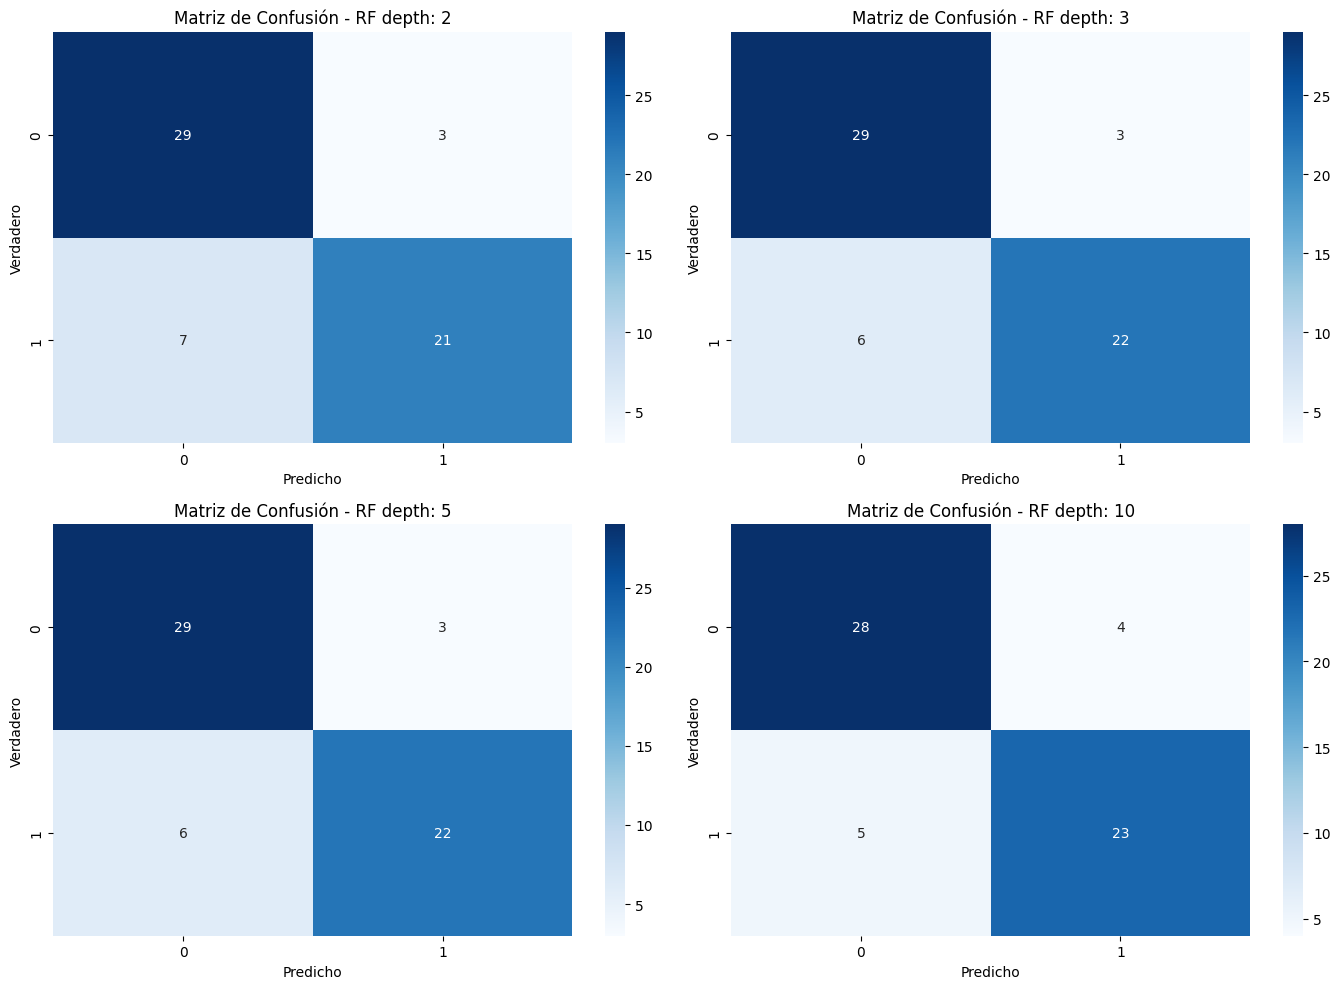

--- Evaluación de Gradient Boosting para depth: 2---
Accuracy: 0.8667

Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.88      0.88        32
         Yes       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

--- Evaluación de Gradient Boosting para depth: 3---
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.84      0.86        32
         Yes       0.83      0.86      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

--- Evaluación de Gradient Boosting para depth: 5---
Accuracy: 0.7667

Classification Report:
              precision    recall  f1-score   support

         

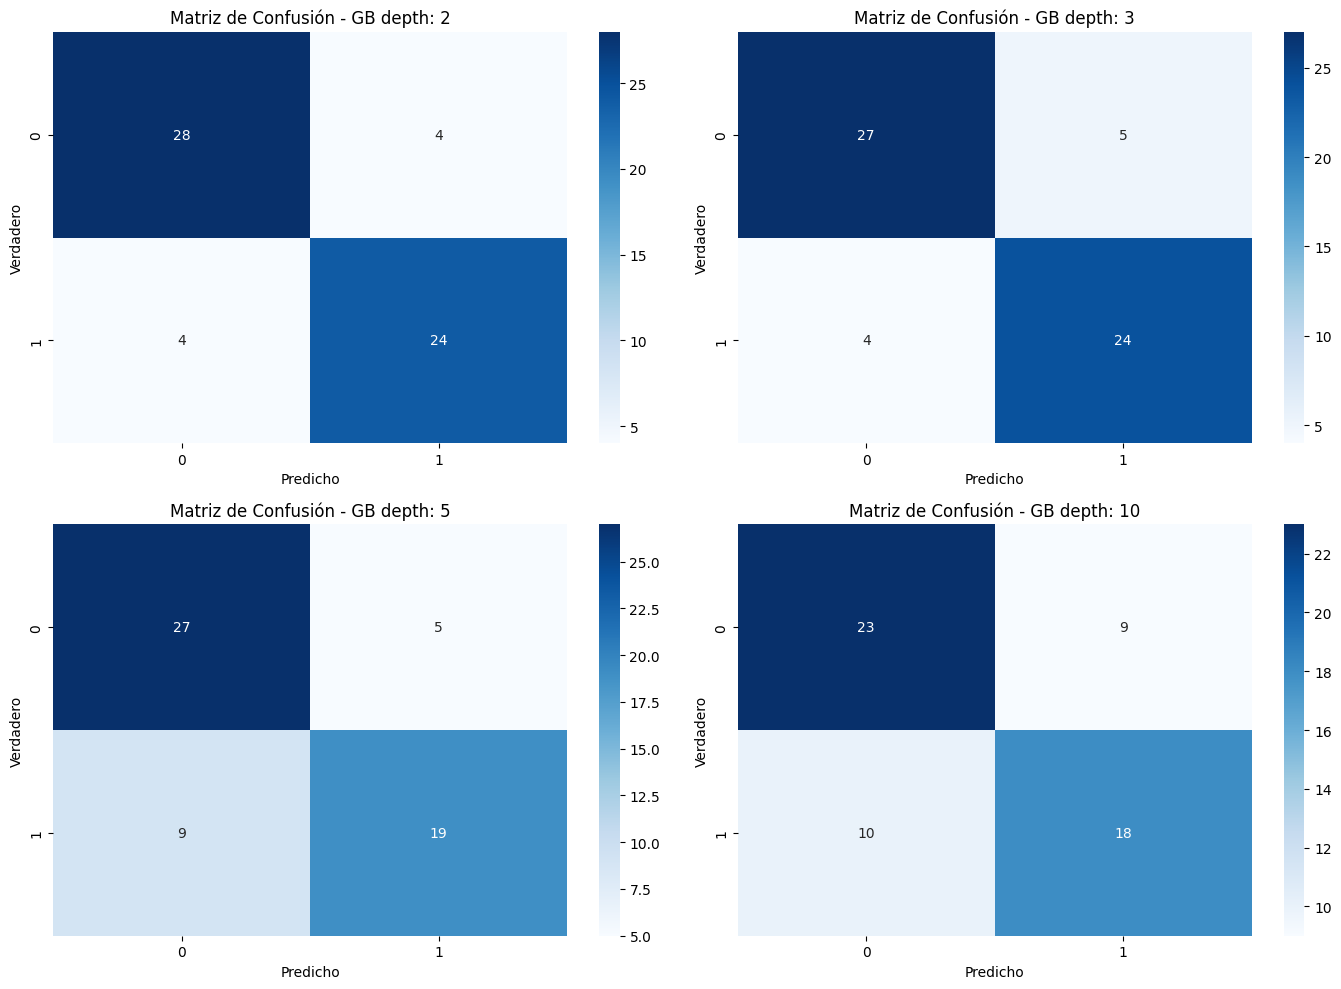

In [111]:
depths=[2,3,5,10]


rf_models={}
for depth in depths:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=100, oob_score=True,max_depth=depth)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    rf_model_data={'model_name': 'RF',
                   'model': rf_model,
                   'pred': y_pred_rf,
                   'accuracy':accuracy_score(y_test, y_pred_rf),
                   'precision': precision_score(y_test,y_pred_rf,pos_label='Yes')}
    rf_models[depth]=rf_model_data
   # Evaluar el rendimiento
    print("--- Evaluación de Random Forest ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"Error OOB (Out-of-Bag): {1 - rf_model.oob_score_:.4f}") # Error OOB
    print(f"Accuracy OOB: {rf_model.oob_score_:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))

draw_confusion_matrix(y_test,rf_models)


gb_models={}
for depth in depths:
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    gb_model_data={'model_name': 'GB',
                   'model': gb_model,
                   'pred': y_pred_gb,
                   'accuracy':accuracy_score(y_test, y_pred_gb),
                   'precision': precision_score(y_test,y_pred_gb,pos_label='Yes')}
    gb_models[depth]=gb_model_data
    # Evaluar el rendimiento
    print(f"--- Evaluación de Gradient Boosting para depth: {depth}---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_gb))
        
draw_confusion_matrix(y_test,gb_models)



En los modelos de RF como se ve que el 1-OOB aumenta entonces hay mas errores, por lo tanto puede haber overfitting. 
En el caso de boosting el accuracy empeora a medida que son mas los árboles.

### 2 Búsqueda de hiperparámetros con GridSearchCV: Utilizar GridSearchCV para encontrar la combinación optima de hipeerprámetros para el RandomForestClassifier. Busca sobre n_estimatos, max_depth y max_features

In [94]:

from sklearn.model_selection import GridSearchCV

gridSearchRF= GridSearchCV(
    estimator=RandomForestClassifier(random_state=100, oob_score=True),
    param_grid={'n_estimators': [50, 100, 200,300,400,500,800,1000], 'max_depth': [None,1,2,3, 5, 10],"max_features": ['sqrt', 'log2']},
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

gridSearchRF.fit(X_train, y_train)

# Entrenar el modelo con los datos de entrenamiento
rf_model_gridcv=gridSearchRF.best_estimator_
print(f"Mejores parámetros encontrados: {gridSearchRF.best_params_}")



Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores parámetros encontrados: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500}


In [29]:
# Extraer la importancia de las variables
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Crear un DataFrame para facilitar la visualización


importances = rf_model_gridcv.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar con Plotly Express
fig = px.bar(
    importance_df.head(15), 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    title='Importancia de las Variables (Random Forest)',
    labels={'Feature': 'Variable', 'Importance': 'Importancia'}
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

### Mejores parámetros encontrados: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500}

###  3 Visularlizar el Error OOB: En el modelo de RF, el atributo oob_score_ se calcula sobre el ensable final. Para visulalizar la curva, entrena varios modelos con diferentes n_estimators (de 10 a 200) y grafica el error OOB (1-oob_score) en funcion del número de árboles

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:611: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



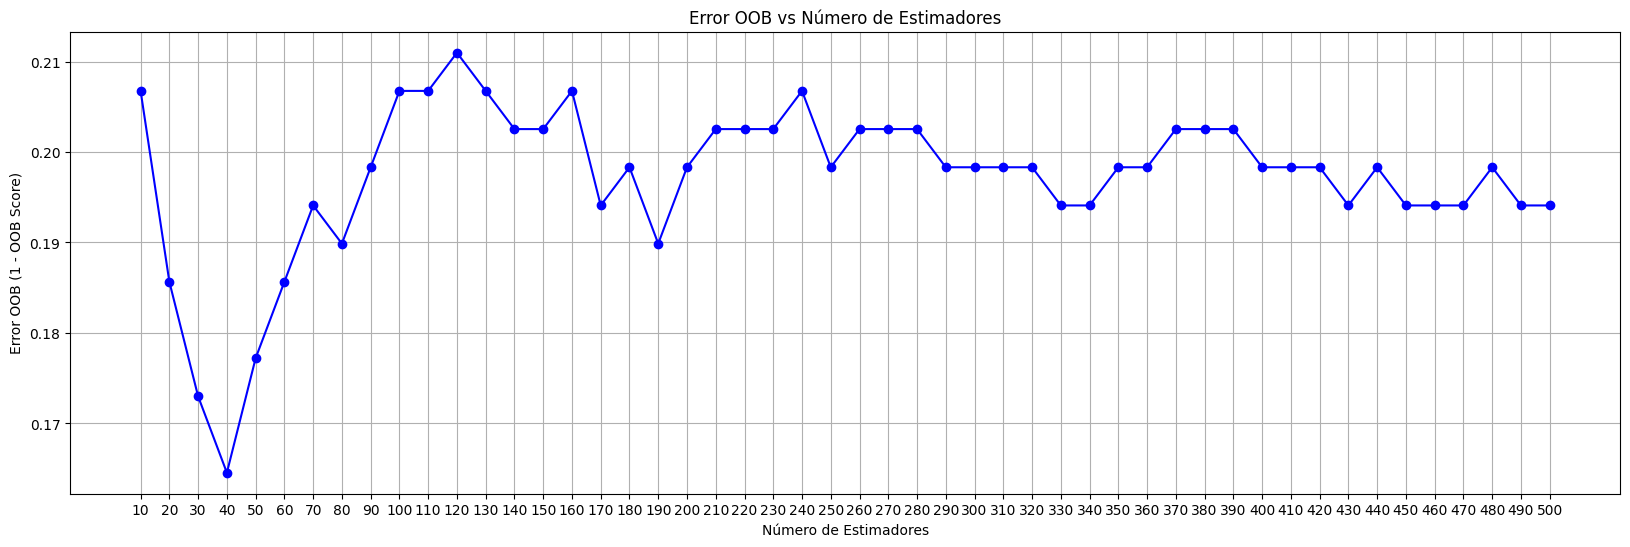

In [113]:
#calculamos random forest con los mejores parametos encontrados, pero para 10, 20, 50, 100, 150 y 200 estimators
estimators=range(10, 501, 10)
oob_scores=[]
for n_estimators in estimators:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=100, oob_score=True,max_depth=3,max_features='sqrt')
    rf_model.fit(X_train, y_train)
    oob_scores.append(1 - rf_model.oob_score_)  # Guardamos el error OOB

# Visualizar el Error OOB
plt.figure(figsize=(20, 6))
plt.plot(estimators, oob_scores, marker='o', linestyle='-', color='blue')
plt.title('Error OOB vs Número de Estimadores')
plt.xlabel('Número de Estimadores')     
plt.ylabel('Error OOB (1 - OOB Score)')
plt.xticks(estimators)
plt.grid()
plt.show()  

#### Me da que la mejor cantida de estimadores es 500, pero el ERROR OOB mejor da con 40. Parece inconsistente pero no lo es porque estamos haciendo dos cosas diferentes, una un gridSearch con cross validation y otra con out-of-bags, Tiene un pico luego de 40 y cerca de los 160-200 se estabiliza.

### 4
Probar un dataset diferente> cargar el dataset de cancer y aplicar RF y GB comparando los resultados

In [36]:
from sklearn.datasets import load_breast_cancer
# Cargamos el dataset. `as_frame=True` nos lo devuelve como un DataFrame de pandas.
data_cancer = load_breast_cancer(as_frame=True)
df_cancer = data_cancer.frame

# Separamos las características (X) y la variable objetivo (y)
X_cancer = df_cancer[data_cancer.feature_names]
y_cancer = df_cancer['target']

# Nombres de las clases (0: Maligno, 1: Benigno)
print(f"Nombres de las clases: {data_cancer.target_names}")

# Echamos un vistazo a las primeras filas del dataset
print("\nPrimeras 5 filas de características:")
display(X_cancer.head())

# Resumen del dataset
print("\nInformación del DataFrame:")
X_cancer.info()

Nombres de las clases: ['malignant' 'benign']

Primeras 5 filas de características:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14

In [37]:
## implemento el Random Forest con los mejores parámetros encontrados
rf_model_cancer = RandomForestClassifier(n_estimators=200, max_depth=3, max_features='sqrt', random_state=100, oob_score=True)
# Dividir el dataset en entrenamiento y prueba (80% / 20%)
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)
# Entrenar el modelo con los datos de entrenamiento
rf_model_cancer.fit(X_train_cancer, y_train_cancer)
# Realizar predicciones sobre el conjunto de prueba
y_pred_rf_cancer = rf_model_cancer.predict(X_test_cancer)
# Evaluar el rendimiento
print("--- Evaluación de Random Forest en el dataset de Cáncer ---")
print(f"Accuracy: {accuracy_score(y_test_cancer, y_pred_rf_cancer):.4f}")
print(f"Error OOB (Out-of-Bag): {1 - rf_model_cancer.oob_score_:.4f}") # Error OOB
print(f"Accuracy OOB: {rf_model_cancer.oob_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cancer, y_pred_rf_cancer))




--- Evaluación de Random Forest en el dataset de Cáncer ---
Accuracy: 0.9474
Error OOB (Out-of-Bag): 0.0462
Accuracy OOB: 0.9538

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



--- Evaluación de Gradient Boosting en el dataset de Cáncer ---
Accuracy: 0.9561

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



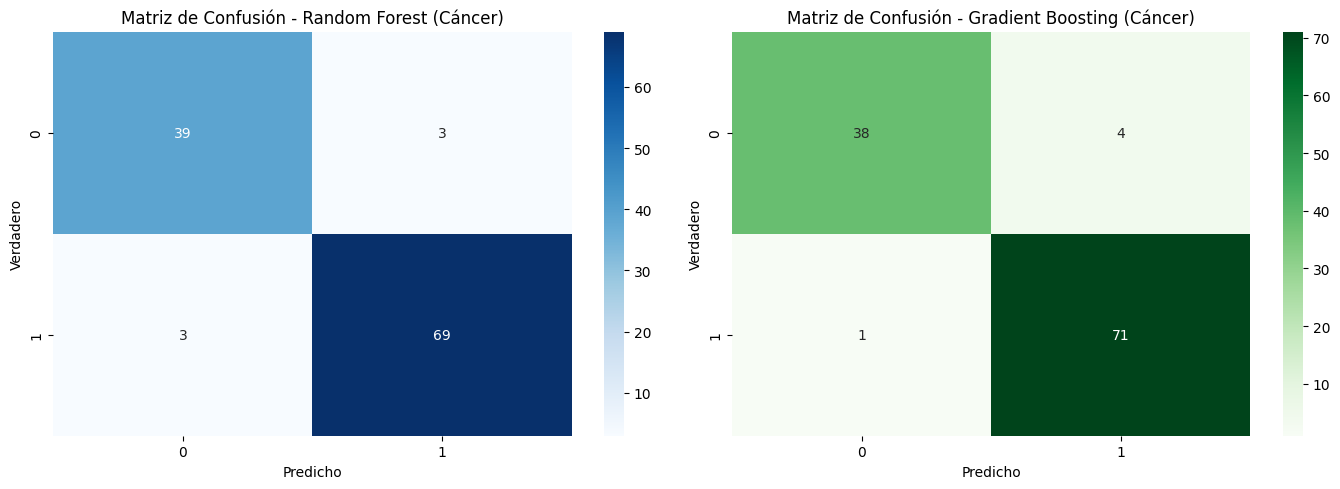

In [38]:
## implemento el Gradient Boosting con los mejores parámetros encontrados
gb_model_cancer = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# Entrenar el modelo
gb_model_cancer.fit(X_train_cancer, y_train_cancer)
# Realizar predicciones
y_pred_gb_cancer = gb_model_cancer.predict(X_test_cancer)
# Evaluar el rendimiento
print("--- Evaluación de Gradient Boosting en el dataset de Cáncer ---")
print(f"Accuracy: {accuracy_score(y_test_cancer, y_pred_gb_cancer):.4f}")
print("\nClassification Report:")   
print(classification_report(y_test_cancer, y_pred_gb_cancer))
# Calcular matrices de confusión
cm_rf_cancer = confusion_matrix(y_test_cancer, y_pred_rf_cancer)
cm_gb_cancer = confusion_matrix(y_test_cancer, y_pred_gb_cancer)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm_rf_cancer, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Random Forest (Cáncer)')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Verdadero')
sns.heatmap(cm_gb_cancer, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Gradient Boosting (Cáncer)')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Verdadero')
plt.tight_layout()
plt.show()  




### 5 Implementamos el Adaboost con el dataset de heart y comparamos el rendimiento con el GrandientBoostingClassifier

--- Evaluación de AdaBoost ---
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.84      0.86        32
         Yes       0.83      0.86      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



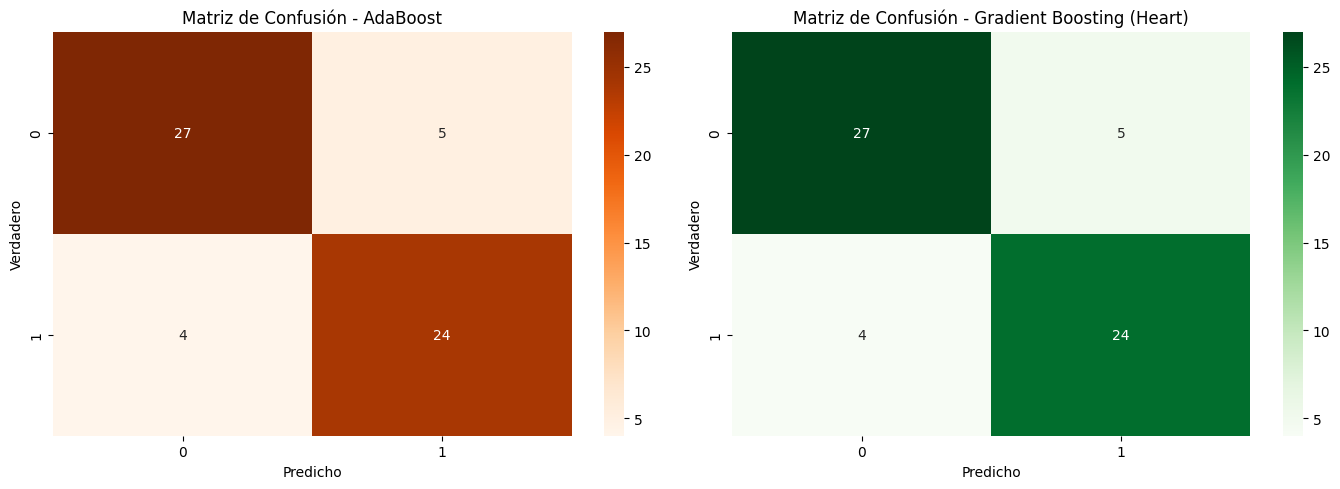

In [115]:
# Creamos el adaboost con el dataset de heart
from sklearn.ensemble import AdaBoostClassifier 
# Instanciar el clasificador de AdaBoost
# n_estimators: número de árboles secuenciales.
# base_estimator: el modelo base que se va a mejorar (a menudo un árbol de
# decisión).
# learning_rate: factor de contracción (shrinkage) para cada árbol.
ada_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)
# Entrenar el modelo
ada_model.fit(X_train, y_train)
# Realizar predicciones
y_pred_ada = ada_model.predict(X_test)
# Evaluar el rendimiento
print("--- Evaluación de AdaBoost ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ada))
# Calcular matrices de confusión
cm_ada = confusion_matrix(y_test, y_pred_ada)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Oranges', ax=axes[0])

axes[0].set_title('Matriz de Confusión - AdaBoost')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Verdadero')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Gradient Boosting (Heart)')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Verdadero')
plt.tight_layout()
plt.show() 


### 6 Curva de aprendizaje en boosting
Para el modelo GB se puede acceder al error en cada etapa de la construccion secuencial. Utilizar el método staged_predict() para obtener las predicciones en cada iteración y graficar el error de prueba en funcion del numero de arboles.

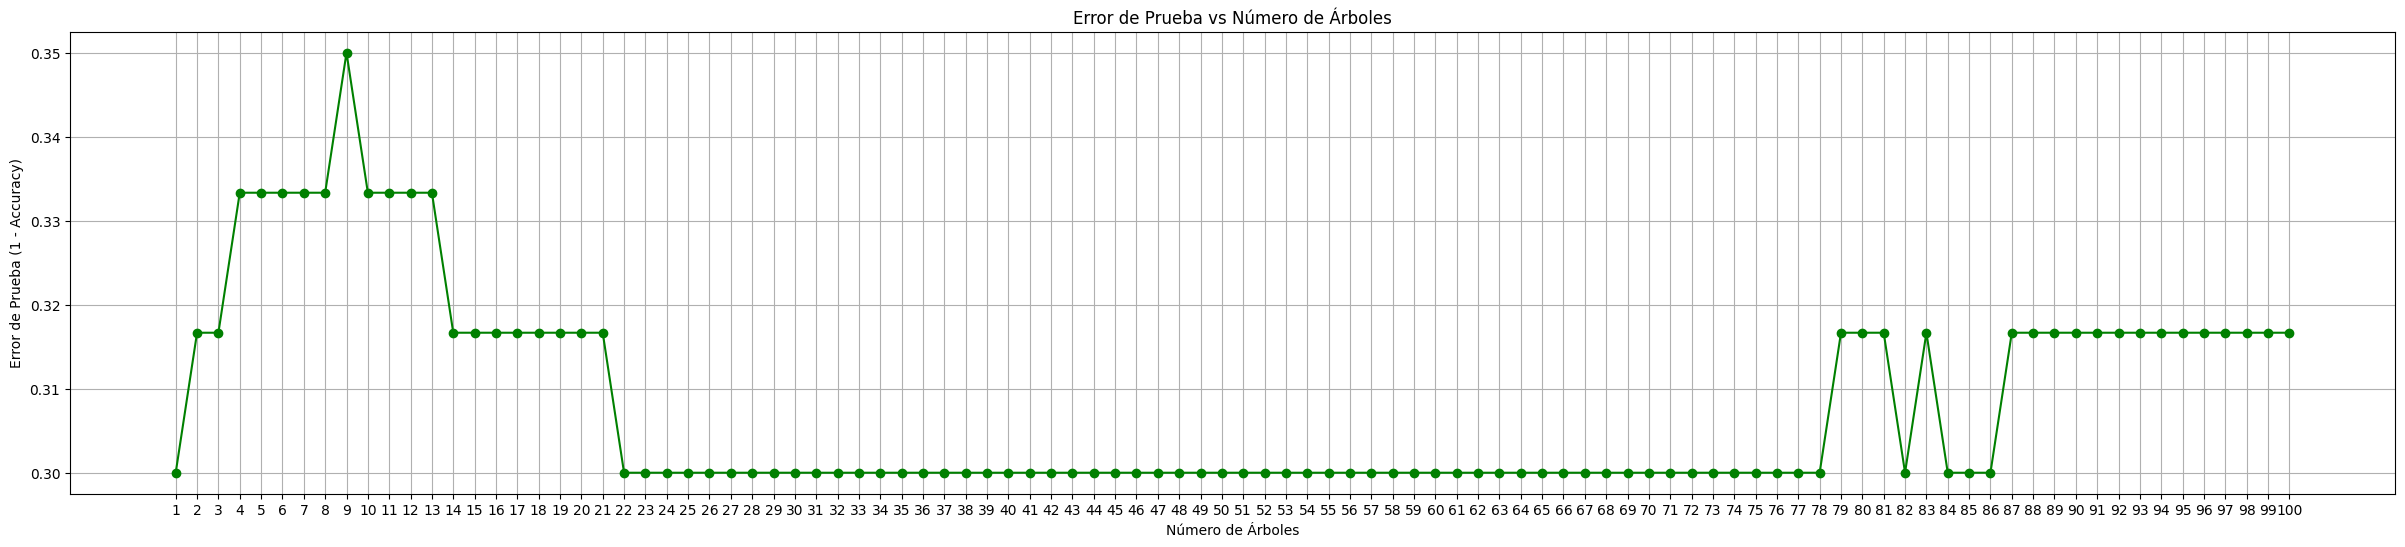

In [116]:
## Para el grandientBoosting acceso al staged_predit de cada iteracion y grafico el error en funcion del numero de arboles
# Obtener las predicciones en cada etapa
staged_predictions = gb_model.staged_predict(X_test)
# Calcular el error en cada etapa
errors = [1 - accuracy_score(y_test, pred) for pred in staged_predictions]
# Graficar el error en función del número de árboles
plt.figure(figsize=(30, 6))
plt.plot(range(1, len(errors) + 1), errors, marker='o', linestyle='-', color='green')
plt.title('Error de Prueba vs Número de Árboles')
plt.xlabel('Número de Árboles')
plt.ylabel('Error de Prueba (1 - Accuracy)')
plt.xticks(range(1, len(errors) + 1))
plt.grid()
plt.show()  


#### Para 100 iteraciones en el 77 sube y vueve a bajar en en el 86 para qudarse arriba de nuevo a partir de ahí

### 7 Importancia de las variables en boosting: Al igual que con RF, los modelos de GB tambien tienen el atributo feature_importance_. Extraer y visulizar la importanncia de las variables para el modelo gb_model. 

In [50]:
## para el modelo gb_model extraigo el atributo feature_importance_ y lo visualizo
# Extraer la importancia de las variables
importances = gb_model.feature_importances_
feature_names = X_encoded.columns
# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Visualizar con Plotly Express
fig = px.bar(
    importance_df.head(15), 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    title='Importancia de las Variables (Gradient Boosting)',
    labels={'Feature': 'Variable', 'Importance': 'Importancia'}
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})    
fig.show()

#### Se puede ver que las features no tienen la misma importancia para GB que para RF.

### Análisis de probabilidades. En lugar de predecir la clase directamente con .predict() utilizar predict_proba() para obtener las probabilidades

In [101]:
import plotly.express as px
import plotly.graph_objects as go

# Probabilidades para la clase positiva
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Crear figura manualmente con go.Figure
fig = go.Figure()

# Agregar histograma de Random Forest
fig.add_trace(go.Histogram(
    x=y_proba_rf,
    nbinsx=20,
    name='Random Forest',
    opacity=0.6,
    marker_color='blue'
))

# Agregar histograma de Gradient Boosting
fig.add_trace(go.Histogram(
    x=y_proba_gb,
    nbinsx=20,
    name='Gradient Boosting',
    opacity=0.6,
    marker_color='orange'
))

# Configurar layout
fig.update_layout(
    title='Distribución de Probabilidades - Clase Positiva (1)',
    xaxis_title='Probabilidad',
    yaxis_title='Frecuencia',
    barmode='overlay',
    width=800,
    height=500
)

fig.show()


In [102]:
## matriz para las predicciones con probabilidades
def confusion_matrix_proba(y_test, y_proba, threshold=0.5):
    # Convertir las probabilidades a clases usando el umbral
    y_pred = (y_proba >= threshold).astype(int)
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    return cm

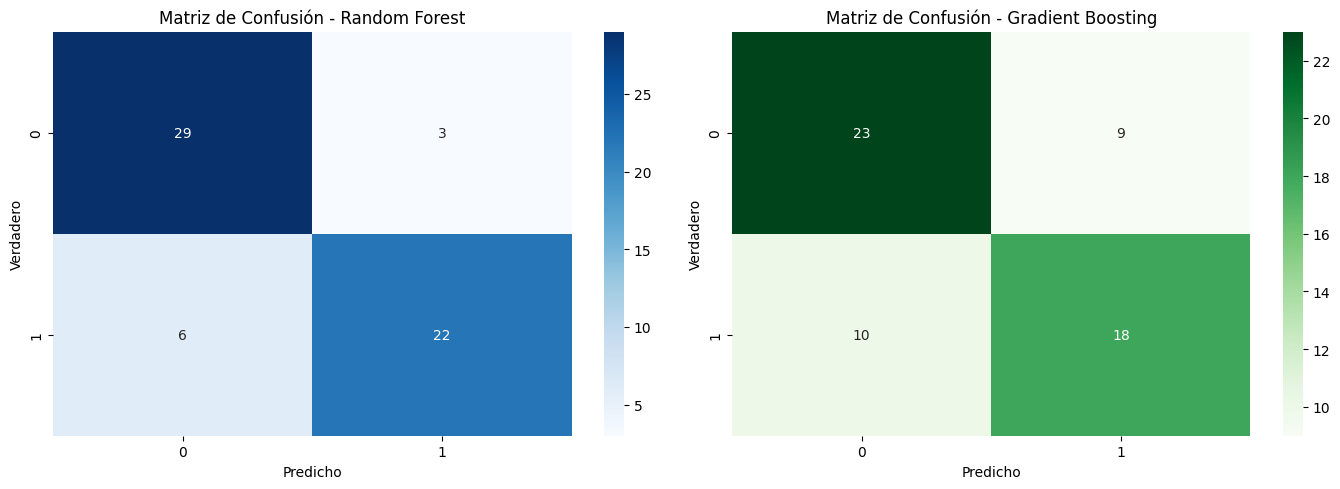

In [118]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_binario = le.fit_transform(y_test) 
cm_proba_rf=confusion_matrix_proba(y_test_binario, y_proba_rf, threshold=0.5)
cm_proba_gb=confusion_matrix_proba(y_test_binario, y_proba_gb, threshold=0.5)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_proba_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Random Forest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Verdadero')

sns.heatmap(cm_proba_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Gradient Boosting')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Verdadero')

plt.tight_layout()
plt.show()

#### Se puede ajustar el humbral hacia abajo (0.1 por ejemplo) aunque aumenta mucho los falso negativos. GB parece ser mucho menos sensible, por que?

### 9.
Investigar XGBoost. Implementar la xgboost y compararla con GradientBoostingClasiffier

--- Evaluación de XGBoost ---
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



/opt/anaconda3/envs/islp/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[10:36:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




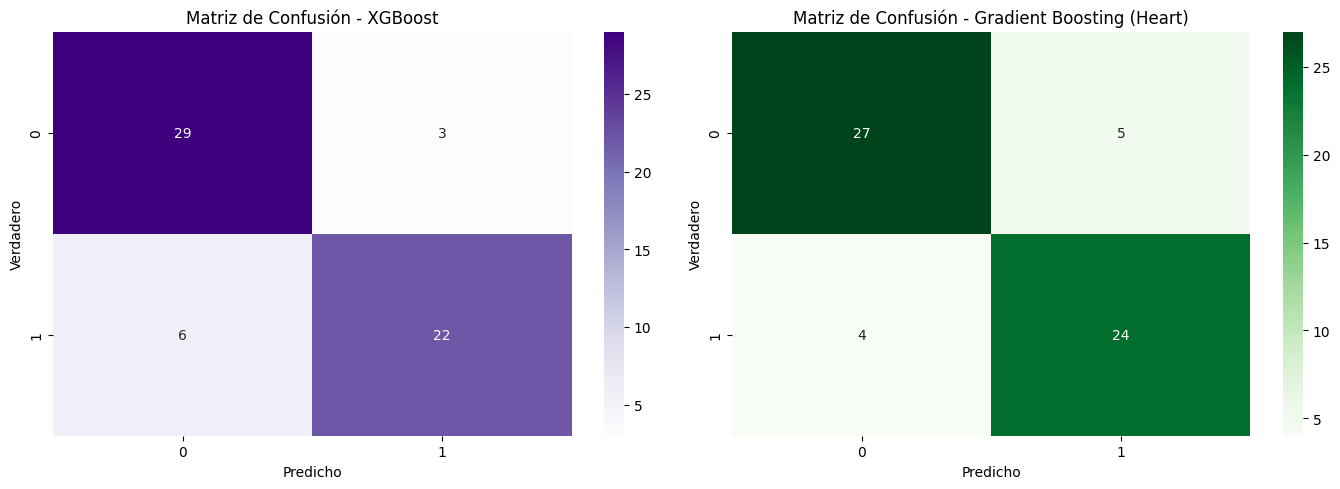

In [121]:
# Implemento XGBoost para luego compararlo con GradientBoostingClassifier
from xgboost import XGBClassifier
# Instanciar el clasificador XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')

y_train_binario = le.fit_transform(y_train) 

# Entrenar el modelo
xgb_model.fit(X_train, y_train_binario)
# Realizar predicciones
y_pred_xgb = xgb_model.predict(X_test)
# Evaluar el rendimiento
print("--- Evaluación de XGBoost ---")
print(f"Accuracy: {accuracy_score(y_test_binario, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_binario, y_pred_xgb))
# Calcular matrices de confusión
cm_xgb = confusion_matrix(y_test_binario, y_pred_xgb)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', ax=axes[0])
axes[0].set_title('Matriz de Confusión - XGBoost')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Verdadero')
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Gradient Boosting (Heart)')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Verdadero')
plt.tight_layout()
plt.show()  




### 10
XGBoost tiene menos falsos positivos pero tiene mas falsos negativos. En ese sentido es mjor GB. GB es menos sensible a la probabilidad lo que no permite un buen ajuste del umbral si es que se necesita. 
En términos de accuracy, precision y recall los valores alcanzados son los mimos para RF y para XGboost. 
Por cuestioens de simpeleza y posiblidad de tunear RF es un mejor modelo para subir a producción.
